In [1]:
import torch
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import codecs


from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, auc
from sklearn.model_selection import KFold
from tqdm import tqdm
from torch.utils import data
from torch import nn

from DeepPurpose import DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
# from deepchem.feat.smiles_tokenizer import SmilesTokenizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
import rdkit
from rdkit import Chem

import torch
import esm

tok_to_idx = {
    "<cls>": 0,
    "<pad>": 1,
    "<sep>": 2,
    "<unk>": 3,
    "<mask>": 91
}

MAX_DRUG_LEN = 50
MAX_PROT_LEN = 545

smile_to_idx = { "#": 4, "%": 5, ")": 6, "(": 7, "+": 8, "-": 9, 
                ".": 10, "1": 11, "0": 12, "3": 13, "2": 14, "5": 15, 
                "4": 16, "7": 17, "6": 18, "9": 19, "8": 20, "=": 21, 
                "A": 22, "C": 23, "B": 24, "E": 25, "D": 26, "G": 27,
                "F": 28, "I": 29, "H": 30, "K": 31, "M": 32, "L": 33, 
                "O": 34, "N": 35, "P": 36, "S": 37, "R": 38, "U": 39, 
                "T": 40, "W": 41, "V": 42, "Y": 43, "[": 44, "Z": 45, 
                "]": 46, "_": 47, "a": 48, "c": 49, "b": 50, "e": 51, 
                "d": 52, "g": 53, "f": 54, "i": 55, "h": 56, "m": 57, 
                "l": 58, "o": 59, "n": 60, "s": 61, "r": 62, "u": 63,
                "t": 64, "y": 65}

fasta_to_idx = { "A": 66, "C": 67, "B": 68, "E": 69, "D": 70, "G": 71, 
                "F": 72, "I": 73, "H": 74, "K": 75, "M": 76, "L": 77, 
                "O": 78, "N": 79, "Q": 80, "P": 81, "S": 82, "R": 83, 
                "U": 84, "T": 85, "W": 86, "V": 87, "Y": 88, "X": 89, 
                "Z": 90 }

def label_smiles(line, MAX_SMI_LEN, smi_ch_ind):
    X = np.ones(MAX_SMI_LEN)
    for i, ch in enumerate(line[:MAX_SMI_LEN]): #x, smi_ch_ind, y
        X[i] = smi_ch_ind[ch]

    return X #.tolist()

def label_sequence(line, MAX_SEQ_LEN, smi_ch_ind):
    X = np.ones(MAX_SEQ_LEN)

    for i, ch in enumerate(line[:MAX_SEQ_LEN]):
        X[i] = smi_ch_ind[ch]

    return X #.tolist()

def encode_data(drug, target):
    card = len(drug)
    print(card)
    encoded_drug = [label_smiles(x, MAX_DRUG_LEN, smile_to_idx) for x in drug]
    encoded_target = [label_sequence(x, MAX_PROT_LEN, fasta_to_idx) for x in target]
    
    feature_vec = np.concatenate([np.concatenate([encoded_drug,[[2]]*card], axis=1),encoded_target], axis=1)
    return feature_vec
    


In [15]:
bob = np.array([(1,2), (2, 3), (4, 5)])

bob

array([[1, 2],
       [2, 3],
       [4, 5]])

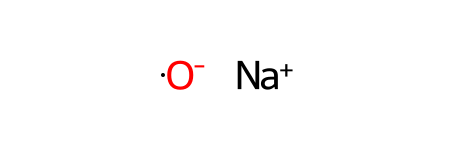

In [37]:
m = Chem.MolFromSmiles('[Na+].[O-]')
m

In [40]:
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /Users/zdx_macos/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /Users/zdx_macos/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


In [42]:
batch_converter = alphabet.get_batch_converter()

In [44]:
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)



In [51]:
alphabet.tok_to_idx

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [47]:
batch_tokens

tensor([[ 0, 20, 15, 11,  7, 10, 16,  9, 10,  4, 15,  8, 12,  7, 10, 12,  4,  9,
         10,  8, 15,  9, 14,  7,  8,  6,  5, 16,  4,  5,  9,  9,  4,  8,  7,  8,
         10, 16,  7, 12,  7, 16, 13, 12,  5, 19,  4, 10,  8,  4,  6, 19, 17, 12,
          7,  5, 11, 14, 10,  6, 19,  7,  4,  5,  6,  6,  2,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1],
        [ 0, 15,  5,  4, 11,  5, 10, 16, 16,  9,  7, 18, 13,  4, 12, 10, 13, 21,
         12,  8, 16, 11,  6, 20, 14, 14, 11, 10,  5,  9, 12,  5, 16, 10,  4,  6,
         18, 10,  8, 14, 17,  5,  5,  9,  9, 21,  4, 15,  5,  4,  5, 10, 15,  6,
          7, 12,  9, 12,  7,  8,  6,  5,  8, 10,  6, 12, 10,  4,  4, 16,  9,  9,
          2,  1,  1,  1,  1,  1],
        [ 0, 15,  5,  4, 11,  5, 10, 16, 16,  9,  7, 18, 13,  4, 12, 10, 13,  3,
          3,  3,  3,  3,  3, 12,  8, 16, 11,  6, 20, 14, 14, 11, 10,  5,  9, 12,
          5, 16, 10,  4,  6, 18, 10,  8, 14, 17,  5,  5,  9,  9, 21,  4, 15,  5,
          4,  5, 10, 15,  6,  7, 12,  9, 

In [52]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

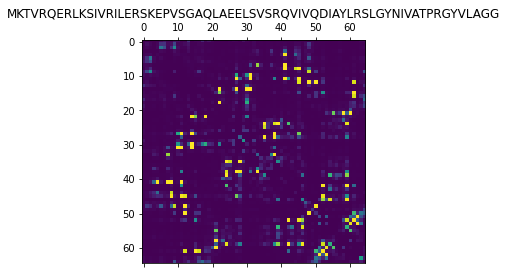

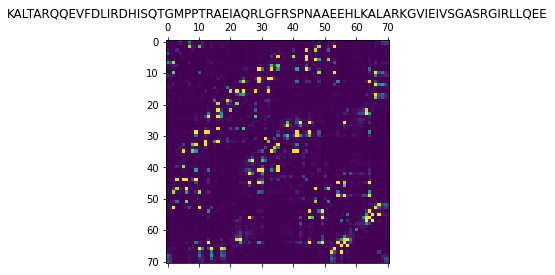

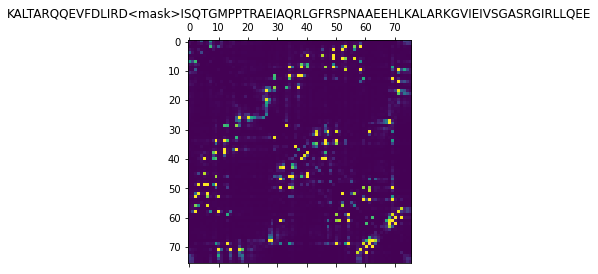

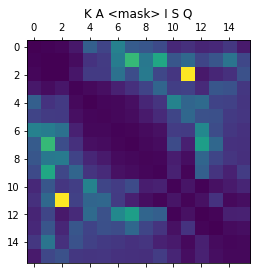

In [54]:
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
    
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)
    plt.show()

In [4]:
SAVE_PATH="./test_data"
X_drug, X_target, y  = load_process_DAVIS(path=SAVE_PATH,
                                         binary = False, 
                                         convert_to_log = True,
                                         threshold = 30)

Beginning Processing...
100% [..................................................................] 179878 / 179878Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!


In [18]:
df = encode_data(X_drug, X_target)

30056


In [9]:
df[:5, :100]

array([[23., 23., 11., 21., 23., 14., 23., 21., 23.,  7., 23., 21., 23.,
        23., 14., 21., 35., 35., 11.,  6., 23., 13., 21., 23., 23.,  7.,
        21., 23., 35., 21., 23., 13.,  6., 34., 23., 23.,  7., 23., 23.,
        16., 21., 23., 23., 21., 23., 23., 21., 23., 16.,  6.,  2., 76.,
        75., 75., 72., 72., 70., 82., 83., 83., 69., 80., 71., 71., 82.,
        71., 77., 71., 82., 71., 82., 82., 71., 71., 71., 71., 82., 85.,
        82., 71., 77., 71., 82., 71., 88., 73., 71., 83., 87., 72., 71.,
        73., 71., 83., 80., 80., 87., 85., 87., 70.],
       [23., 23., 11., 21., 23., 14., 23., 21., 23.,  7., 23., 21., 23.,
        23., 14., 21., 35., 35., 11.,  6., 23., 13., 21., 23., 23.,  7.,
        21., 23., 35., 21., 23., 13.,  6., 34., 23., 23.,  7., 23., 23.,
        16., 21., 23., 23., 21., 23., 23., 21., 23., 16.,  6.,  2., 81.,
        72., 86., 75., 73., 77., 79., 81., 77., 77., 69., 83., 71., 85.,
        88., 88., 88., 72., 76., 71., 80., 80., 81., 71., 75., 87., 77

In [152]:
print(df.shape)
print(y.shape)

(30056, 596)
(30056,)


(array([ 5561.,  1248.,   739.,   505.,   339.,   259.,   168.,   132.,
           93., 21012.]),
 array([1.6000000e-02, 1.0000144e+03, 2.0000128e+03, 3.0000112e+03,
        4.0000096e+03, 5.0000080e+03, 6.0000064e+03, 7.0000048e+03,
        8.0000032e+03, 9.0000016e+03, 1.0000000e+04]),
 <BarContainer object of 10 artists>)

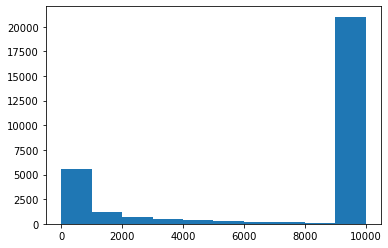

In [155]:
plt.hist(y)


In [7]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1)


In [ ]:

model = Lasso(alpha=0.05).fit(X_train, y_train)
print("R2: ", model.score(X_train, y_train))

y_pred = model.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))

In [8]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=1000, max_depth=5, tree_method="auto").fit(X_train, y_train)


In [10]:
from sklearn.metrics import roc_auc_score, precision_recall_curve
from lifelines.utils import concordance_index

print("R2: ", xgb.score(X_train, y_train))
y_pred = xgb.predict(X_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("CI: ", concordance_index(y_test, y_pred))

R2:  0.926394437132814
MSE:  0.4382923200413326
CI:  0.8094102543481547


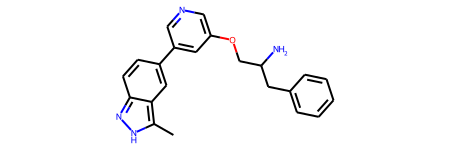

In [18]:
ex = Chem.MolFromSmiles(X_drug[0])
ex


In [ ]:
drug_max_len = 50 #MolTrans
protein_max_len = 545 #MolTrans

def drug_encoder(smile):
    print(smile)
    
def protein_encoder(seq):
    print(seq)
    
def load_data(folder_name):
    df_train = pd.read_csv(folder_name + '/train.csv')
    df_val = pd.read_csv(folder_name + '/val.csv')
    df_test = pd.read_csv(folder_name + '/test.csv')
    
    
    

In [3]:
vocab_path = './ESPF/protein_codes_uniprot.txt'
bpe_codes_protein = codecs.open(vocab_path)

In [4]:
bpe_codes_protein

<_io.TextIOWrapper name='./ESPF/protein_codes_uniprot.txt' mode='r' encoding='UTF-8'>